# LIBRAIRIES & FONCTIONS UTILES

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from numpy.linalg import matrix_rank

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge,enet_path, Lasso, LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def backward_one_step(X,
                      Y,
                      estimator,
                      scoring):
    # -------------------------------------------------------------------------
    # /!\ on suppose ici que la premiere colonne de X correspond à l'intercept
    # -------------------------------------------------------------------------
    # on recupere la dimension de X
    p = X.shape[1]
    # vecteur des listes de scores
    all_scores = []
    # => on parcourt toutes les colonnes de X sauf la première
    for j in range(1,p):
        # On crée une matrice temporaire X_tmp qui contient
        # toutes le colonnes de X sauf la j
        # (on supprime la colonne j de X)
        X_tmp = np.delete(np.array(X), j, axis=1)
        # On fit un "estimator" (ici la regression lineaire) de Y vs X_tmp
        estimator.fit(X_tmp,Y)
        # On predit la reponse sur les donnees X_tmp
        Y_pred_tmp = estimator.predict(X_tmp)
        # On calcule le score
        score_tmp = scoring(Y,Y_pred_tmp)
        # On stocke le score
        all_scores += [score_tmp]
    # On retourne la colonne pour laquelle le score est "maximal"
    # /!\ comme on parcourt de 1 à p -> il faut ajouter 1 ...
    j_opt = np.argmax(all_scores)+1
    return j_opt

def backward_stepwise(X,Y,estimator,scoring,random_state=42):
    # -------------------------------------------------------------------------
    # /!\ on suppose ici que la premiere colonne de X correspond à l'intercept
    # -------------------------------------------------------------------------
    p = X.shape[1]
    # creation d'une liste correspondant aux indices initiaux des colonnes de X
    list_index_X = list(range(p))
    # Split Echantillon d'apprentissage / echantillon de test
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y,
                                                      test_size=0.2,
                                                      random_state = random_state)
    # Vecteur des scores calculés à chaque étape (sur X_val)
    all_scores = []
    # Vecteur des composantes à enlever à chaque étape
    removed_list = []

    # Application de la stepwise procedure
    # On ne fera que p-1 iterations (car on laisse l'intercept)
    for j in range(p-1):
        print(f"{j}",end="\r")

        # Sélection de la colonne a enlever
        j_iter = backward_one_step(X_train,
                                   Y_train,
                                   estimator,
                                   scoring)

        # On recupere l'indice j_iter de la colonne a enlever
        removed_list += [list_index_X[j_iter]]
        # On supprime l'indice de list_index_X
        list_index_X = np.delete(list_index_X, j_iter)

        # On supprime la colonne j_iter de X_train & X_val
        X_train = np.delete(np.array(X_train), j_iter, axis=1)
        X_val = np.delete(np.array(X_val), j_iter, axis=1)

        # On fait la regression de Y_train vs X_train
        estimator.fit(X_train,Y_train)
        # On prédit & calcule le score sur X_val
        Y_pred_val = estimator.predict(X_val)
        # On stocke le score
        all_scores += [scoring(Y_val,Y_pred_val)]

    return all_scores,removed_list

## TEST

# from sklearn.datasets import make_regression
# XX,YY,coef = make_regression(n_samples=50,
#                         n_features=10,n_informative=2,random_state=42,
#                         coef=True)
# XX_I = pd.DataFrame(XX)
# XX_I.insert(0,"Intercept",1)

# res = backward_stepwise(XX_I,
#                         YY,
#                         LinearRegression(fit_intercept=False),
#                         r2_score)
# coef[np.array(res[1])-1]

# EXERCICE

* Des données de spectroscopie Infra Rouge ont été recueillies sur différents échantillons de viande
* Pour chaque observation des mesures précises de conteneur en gras ont aussi été réalisées.
Comme les mesures de taux de gras sont compliquées à réaliser, on aimerait construire un prédicteur à partir des données de spectroscopie qui sont plus faciles à obtenir.
___

___

## Lire et explorer les données
* Quelle est la dimension de la matrice $X$
* Faire une régression avec toutes les variables (validez avec echantillon de test/apprentissage)

___

In [2]:
data = pd.read_csv("meatspec.csv")
data.drop(columns="Unnamed: 0", inplace=True)

In [3]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


In [5]:
X = data.drop("fat", axis = 1)
intercept = np.ones(215)
Y = intercept + data["fat"]

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      215 non-null    float64
 1   V2      215 non-null    float64
 2   V3      215 non-null    float64
 3   V4      215 non-null    float64
 4   V5      215 non-null    float64
 5   V6      215 non-null    float64
 6   V7      215 non-null    float64
 7   V8      215 non-null    float64
 8   V9      215 non-null    float64
 9   V10     215 non-null    float64
 10  V11     215 non-null    float64
 11  V12     215 non-null    float64
 12  V13     215 non-null    float64
 13  V14     215 non-null    float64
 14  V15     215 non-null    float64
 15  V16     215 non-null    float64
 16  V17     215 non-null    float64
 17  V18     215 non-null    float64
 18  V19     215 non-null    float64
 19  V20     215 non-null    float64
 20  V21     215 non-null    float64
 21  V22     215 non-null    float64
 22  V

In [7]:
X.shape

(215, 100)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                      test_size=0.2,
                                                      random_state = 42)

In [9]:
LR = LinearRegression()


LR.fit(X_train, Y_train)


Y_pred = LR.predict(X_test)


mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'R² est {r2}')
print(f'Les paramètres estimés {LR.coef_}')
print(f'L intercept est {LR.intercept_}')

R² est 0.7621175213085997
Les paramètres estimés [ 13595.15599518 -16667.55092151  -9194.74946568  28636.83703793
 -32153.82458823  23173.1634546  -20422.56003598   8492.42622182
  13420.57466454 -14799.38147623  -1333.98262704  25362.29611968
 -26477.63343658   9751.45242053   2951.08252367  -4958.627068
  -7398.9204624    6634.78371078  28025.20144313 -39659.84557029
  -6990.97587677  39580.36112471 -14756.07303775 -20730.06959188
  22892.45195374   1097.61340314 -18383.76444895  30244.38221683
 -43871.04595054  39725.91117273 -36588.4106138   44446.16217678
 -29461.72112933   3494.77956617  -4570.38726944   9394.20237418
   2838.46808856 -22496.31304272  31076.28214501 -20405.91121887
  27961.09510659 -47402.07317708  44264.91607888 -38919.37804441
  32152.4922597   -5651.59973792  -7892.54176592   -643.76322191
   2865.46915762  -4124.45425389  12263.4135574  -11230.79804327
  -7940.71876348  26413.07467594 -22387.4063987    5159.76361475
   3636.04698251  -3202.94003727  -2100.619

___

## Régressions et Sélection de variables

La matrice $X$ étant de dimension relativement élevée, nous allons étudier la possibilité de réduire sa dimension en ne selectionnant que certaines variables.
Dans toutes les approches étudiées par la suite, on fera bien attention à utiliser une base de donnée d'apprentissage et une base de donnée de test.

___

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.4655533 , -0.46799703, -0.47028023, ..., -0.37721546,
        -0.38097371, -0.38511829],
       [ 0.06338893,  0.06686112,  0.07013882, ...,  0.27826423,
         0.284502  ,  0.2893148 ],
       [-0.55075794, -0.54937636, -0.54812332, ..., -0.8969317 ,
        -0.89484188, -0.89258136],
       ...,
       [-0.58513748, -0.58659843, -0.58774377, ..., -0.39813364,
        -0.39855302, -0.40026505],
       [-0.36531829, -0.36787329, -0.36992771, ..., -0.20201641,
        -0.20230673, -0.2045555 ],
       [ 0.20027268,  0.1971505 ,  0.19437447, ...,  0.61260149,
         0.6084502 ,  0.60161129]])

In [11]:
#faire un ACP

from sklearn.decomposition import PCA

X -= X.mean(axis=0)
X /= X.std(axis=0)

#ACP
pca = PCA()
pca.fit_transform(X)
n = pca.n_components_

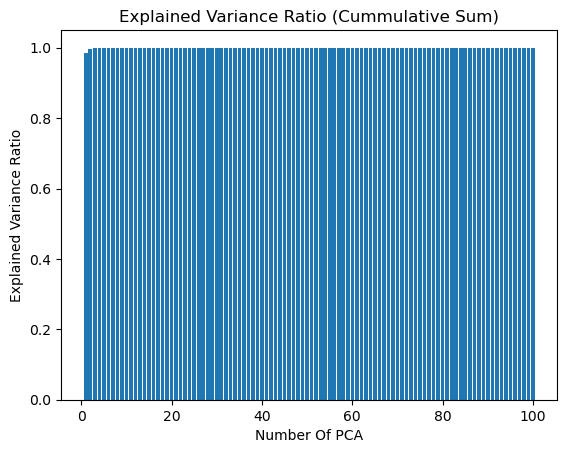

In [12]:
_ = plt.bar(range(1,len(pca.explained_variance_ratio_)+1),
        pca.explained_variance_ratio_.cumsum())
_ = plt.title("Explained Variance Ratio (Cummulative Sum)")
_ = plt.xlabel("Number Of PCA")
_ = plt.ylabel("Explained Variance Ratio")

___

### APPROCHE ALEATOIRE

* On sélectionne de façon aléatoire $K$ composantes et on effectue la régression de Y sur ces $K$ composantes. On calcule le $R^2$ sur une base de données de test.
* On effectuera cette opération plusieurs fois de façon à avoir une valeur moyenne de $R^2$.

Cette valeur servira de point de repère entre un modèle "naïf" (sélection de façon aléatoire) et un modèle où des variables auront été sélectionnées selon une stratégie donnée.

Dans ce qui suit, nous pourrons sélectionner: $K = 5,10,20$

___

In [13]:
list_comp = list(X.columns)

In [14]:
K_values = [5, 10, 20]
n_iterations = 100
results = {}

for K in K_values:
    r2_scores = []

    for _ in range(n_iterations):
        selected_features = np.random.choice(X.columns, size=K, replace=False)

        X_train, X_test, y_train, y_test = train_test_split(X[selected_features], Y, test_size=0.2, random_state=42)


        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

    results[K] = np.mean(r2_scores)

for K, r2_mean in results.items():
    print(f"Moyenne du R² pour K={K}: {r2_mean:.2f}")


Moyenne du R² pour K=5: 0.89
Moyenne du R² pour K=10: 0.95
Moyenne du R² pour K=20: 0.95


___

### APPROCHE STEPWISE
* On applique la procédure stepwise "backward" de façon sélectionner $K$ variables.
* On effectue la régression sur le $K$ variables sélectionnées.
Quelles remarques pouvez vous faire ?

___

In [15]:
estimator = LinearRegression()
scoring = r2_score

In [16]:
print(backward_one_step(X,Y,estimator,scoring))
print(backward_stepwise(X,Y,estimator,scoring,random_state=42))

69
([0.7618639057142752, 0.7650936472004267, 0.7795711404957896, 0.7797613372022981, 0.7812019574120439, 0.7786697758138122, 0.7757659416449745, 0.7734966260248306, 0.7763721107766646, 0.7860249369978711, 0.7924877283010308, 0.7946570717110477, 0.8004421460040803, 0.7980025797802647, 0.7899409983859448, 0.7919631586732823, 0.7989238860383017, 0.7940536339846074, 0.7845207563543453, 0.78084634801701, 0.777738707277402, 0.7874015421620517, 0.7898481088805783, 0.7946378348567757, 0.8002940636636117, 0.8024236078287629, 0.8102205358963508, 0.8516533641601588, 0.8452819263528004, 0.8334947563395826, 0.8381991398100537, 0.8209665752324327, 0.8146105303627834, 0.8160811797763357, 0.801890071023963, 0.8052011927707998, 0.7937117115334977, 0.7983281283854975, 0.8108256829790885, 0.7896237252691398, 0.7913196082916221, 0.8143280784512714, 0.8131429390771973, 0.8142476598813858, 0.8352279625564026, 0.8335983966819678, 0.8675021142381046, 0.8711433696020443, 0.8429553678280928, 0.8412206109096075,

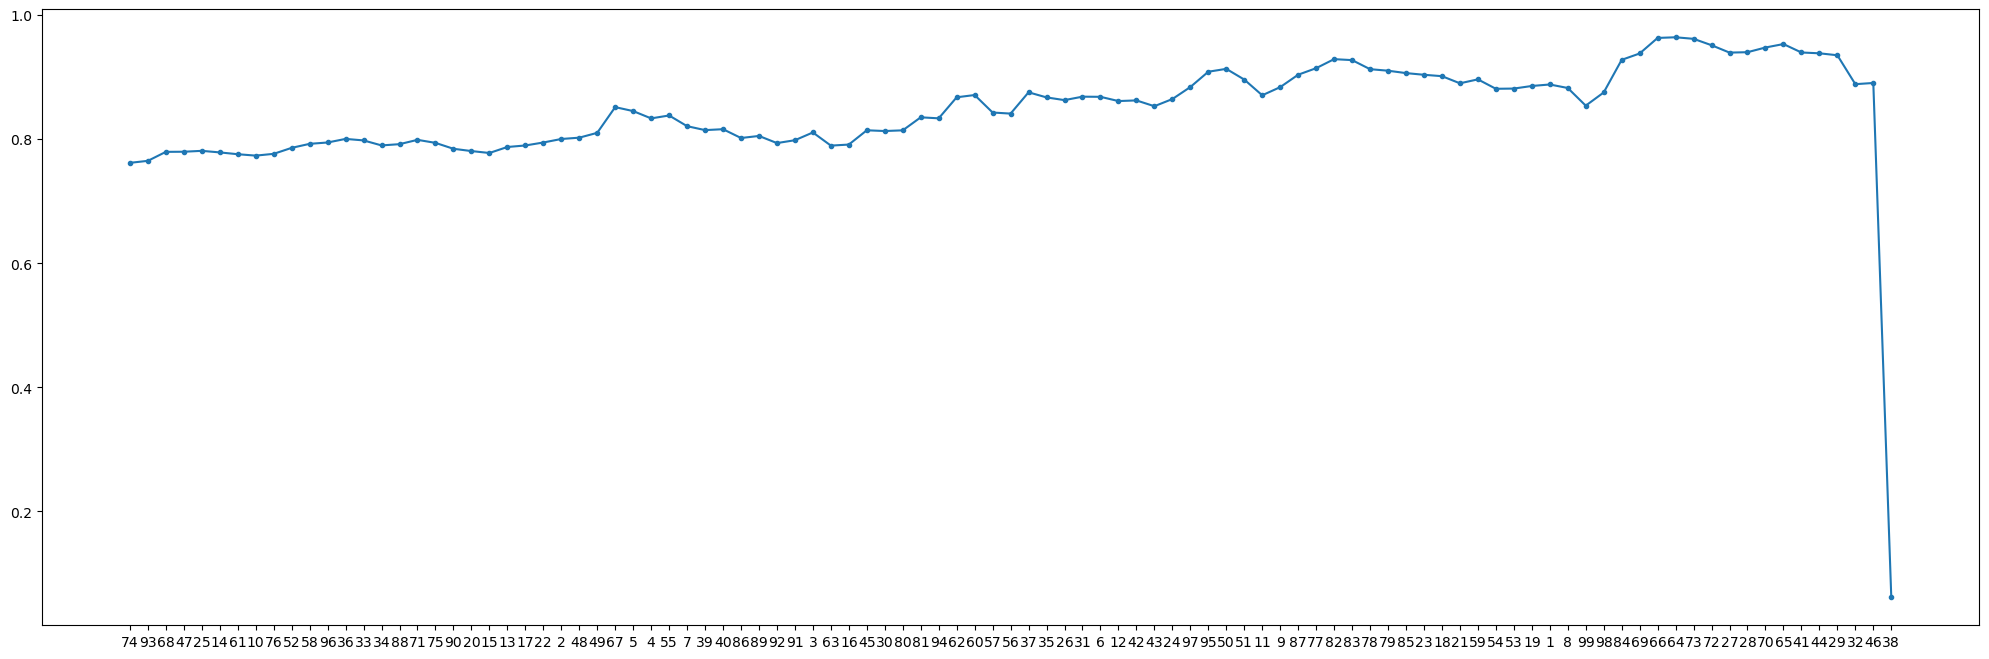

In [17]:
res =  backward_stepwise(X,Y,estimator,scoring,random_state=42)
plt.figure(figsize=(25, 8))
_ = plt.plot(res[0],'.-')

j_opt = np.argmax(res[0])
max_r2_score = res[0][j_opt]
# plt.scatter(j_opt, max_r2_score, color='red', s=100, zorder=3)


_ = plt.xticks(ticks=range(len(res[1])), labels=res[1])


___

### APPROCHE LASSO
* On applique la procédure LASSO de façon sélectionner $K$ variables.
* On effectue la régression sur le $K$ variables sélectionnées.
Quelles remarques pouvez vous faire ?

___

In [18]:
K_values = [5,10,20]
alpha = 0.1
coefs = []


selected_features = np.random.choice(X.columns, size=5, replace=False)
lasso = Lasso(alpha=alpha)
lasso.fit(X[selected_features], Y)
coefs.append(lasso.coef_)

for i in range(X[selected_features].shape[1]):
  print(np.array(coefs)[:,i])


[0.]
[80.06401026]
[0.]
[-74.90598144]
[-0.]


In [19]:
n_alphas = 200
alphas = np.logspace(-1, 2, n_alphas)
coefs  = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X, Y)
    coefs.append(lasso.coef_)

/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380.47184152208547, tolerance: 3.4735444837209304
  positive)
/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373.01021812604813, tolerance: 3.4735444837209304
  positive)
/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361.88944972190893, tolerance: 3.4735444837209304
  positive)
/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceW

/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.22958872442177, tolerance: 3.4735444837209304
  positive)
/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.4883219268877, tolerance: 3.4735444837209304
  positive)
/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.96259032806756, tolerance: 3.4735444837209304
  positive)
/opt/cloudera/parcels/ANACONDA_PYTHON/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWa

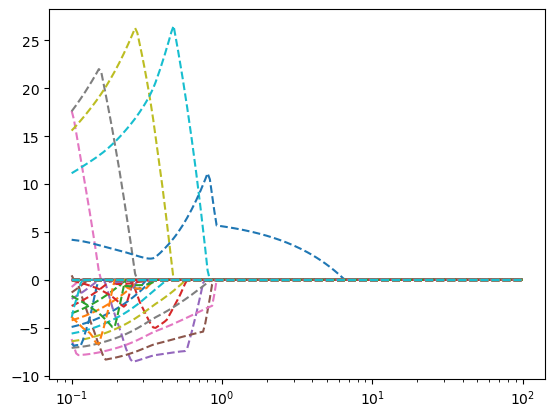

In [20]:
for i in range(X.shape[1]):
  plt.plot(alphas,np.array(coefs)[:,i],linestyle="--")

plt.gca().set_xscale('log')

In [21]:
# plt.figure(figsize=(10, 6))
# plt.plot(alphas, coefs)
# plt.xscale("log")  # Échelle logarithmique
# plt.xlabel("Alpha")
# plt.ylabel("Valeur des coefficients")
# plt.title("Évolution des coefficients du Lasso en fonction d'Alpha")
# plt.show()

___

### AUTRE(S) APPROCHES
* Quelles techniques avez vous vu de façon à réduire la dimension de la matrice $X$ ?
* Que pouvez-vous proposer ?
* Comparer avec les autres approches

___

In [22]:
estim = LinearRegression()
score = make_scorer(r2_score)

In [23]:
score = make_scorer(r2_score)
selection = RFECV(estim, cv=5, scoring=score)

In [24]:
_fit = selection.fit(X,Y)

**RIDGE**

In [25]:
n_alphas = 200
alphas = np.logspace(-1, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X, Y)
    coefs.append(ridge.coef_)

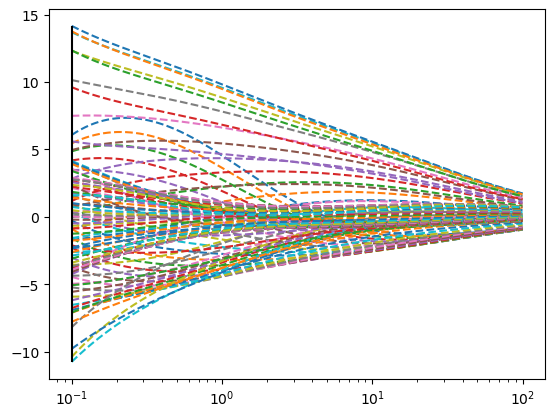

In [26]:
for i in range(X.shape[1]):
  plt.plot(alphas,np.array(coefs)[:,i],linestyle="--")

plt.gca().set_xscale('log')

ridge_cv = RidgeCV(alphas=alphas).fit(X, Y)
plt.vlines(ridge_cv.alpha_,np.min(coefs),np.max(coefs),color="k")